# Station Keeping example
##### Keeping a satellite on its precise path involves executing precise station-keeping maneuvers. In this notebook you'll learn to set up the orbital state, configure a station-keeping strategy, and generate ephemerides.

*To run this example, make sure to have installed the lateste version of the spacetower-python-sdk (1.2.0).*


## Jupyter Notebook Help Guide
Welcome to your Jupyter Notebook! If you need assistance or more information about any function, method, or object, the contextual help window is a valuable tool.

***Important - To have access to contextual help, start by running the [Imports](#imports) section below***

![Run Notebook](https://portal.exotrail.space/images/products/notebooks/execute_workflow.jpg)


### How to Open the Contextual Help Window


1. **Use the Help Menu**:
   - Navigate to the top menu bar and click on `Help`. From the dropdown menu, select `Show Contextual Help`.
2. **Keyboard Shortcut**:
   - Press `Shift + Tab` while your cursor is over the code you want more information on. For a more detailed view, press `Shift + Tab` twice.
3. **Using the Inspector**:
   - Type `?` followed by the function or object name and run the cell. For example, `?print`.
   - To see the full documentation, use `??` instead, e.g., `??print`.


### Tips for Using the Contextual Help


- **Inline Help**: Single press `Shift + Tab` to get a brief pop-up of the docstring.
- **Expanded Help**: Double press `Shift + Tab` or click the expand icon in the pop-up to open the full documentation in the help pane.
- **Persistent Help Pane**: Use the Help menu or `Shift + Tab` twice to dock the help pane on the right side of the screen, where it can stay open as you work.
This feature can help you understand function parameters, return types, and see example usages directly in your notebook. Happy coding!

## Imports

In [ ]:
from datetime import datetime, UTC, timedelta
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from fds.constants import EARTH_RADIUS
from fds.models.actions import ActionFiring
from fds.models.orbital_state import PropagationContext, OrbitalState
from fds.models.orbits import KeplerianOrbit, OrbitMeanOsculatingType, PositionAngleType
from fds.models.spacecraft import SpacecraftBox, ThrusterElectrical, Battery, SolarArray
from fds.models.station_keeping.requests import EphemeridesRequest, SpacecraftStatesRequest
from fds.models.station_keeping.strategy import StationKeepingStrategy
from fds.models.station_keeping.tolerance import SemiMajorAxisTolerance
from fds.models.station_keeping.use_case import LeoStationKeeping
from fds.utils.plotting import add_grid

*Note*: If you are using this notebook locally, use the following methods to configure your credentials:

```python
from fds.config import set_client_id, set_client_secret
set_client_id('CLIENT_ID')
set_client_secret('CLIENT_SECRET')
```

## Create models

### Create Orbital State
`OrbitalState` is the object used in spacetower to group information on the initial orbit and covariance, the propagation context and the spacecraft definition.  


#### Orbit

In [ ]:
orbit = KeplerianOrbit(
    semi_major_axis=EARTH_RADIUS * 1e-3 + 500,
    anomaly=0,
    argument_of_perigee=0,
    eccentricity=1e-3,
    inclination=98,
    raan=90,
    kind=OrbitMeanOsculatingType.MEAN,
    anomaly_kind=PositionAngleType.TRUE,
    date=datetime(2024, 6, 1, tzinfo=UTC)
)

#### Propagation Context

The `PropagationContext` object encapsulates the settings necessary to accurately propagate the satellite's orbit by accounting for gravitational and non-gravitational perturbations. Adjusting these parameters allows for fine-tuning the balance between computational efficiency and the accuracy of the simulation.

In [ ]:
propagation_context = PropagationContext(
    model_perturbations=[
        PropagationContext.Perturbation.DRAG,
        PropagationContext.Perturbation.EARTH_POTENTIAL,
    ],
    model_solar_flux=160,  # SFU
    model_earth_potential_deg=8,
    model_earth_potential_ord=8,
    model_atmosphere_kind=PropagationContext.AtmosphereModel.HARRIS_PRIESTER,
    integrator_kind=PropagationContext.IntegratorKind.DORMAND_PRINCE_853,
    integrator_min_step=0.01,  # s
    integrator_max_step=100,  # s
)

#### Spacecraft

Here we are using the `SpacecraftBox` class to define our spacecraft.  
To define a simpler model, try using the `SpacecraftSphere` class where battery, solar-arrays and thrusters do not need to be defined.

In [ ]:
battery = Battery(
    depth_of_discharge=0.1,  # 0<x<1
    nominal_capacity=200,  # W
    minimum_charge_for_firing=0.99,  # 0<x<1
    initial_charge=1,  # 0<x<1
)

solar_array = SolarArray(
    efficiency=0.3,
    kind=SolarArray.Kind.DEPLOYABLE_FIXED,
    initialisation_kind=SolarArray.InitialisationKind.SURFACE,
    surface=0.5,
    normal_in_satellite_frame=(0.0, -1.0, 0.0),
)

electrical_thruster = ThrusterElectrical(
    isp=2500,  # s
    thrust=0.0005,  # N
    axis_in_satellite_frame=(0, 0, -1),  # Unit vector
    propellant_mass=1.0,  # kg
    wet_mass=3.0,  # kg
    warm_up_duration=0,  # s
    maximum_thrust_duration=2000,  # s
    impulse=40000.0,  # Ns
    power=50,  # W
    stand_by_power=10,  # W
    warm_up_power=0,  # W
)

spacecraft = SpacecraftBox(
    battery=battery,
    thruster=electrical_thruster,
    solar_array=solar_array,
    platform_mass=100,  # kg
    drag_coefficient=2.2,
    reflectivity_coefficient=0.5,
    length_x=.5,  # m
    length_y=.5,  # m
    length_z=.5,  # m
    max_angular_velocity=1,  # deg/s
    max_angular_acceleration=.1,  # deg/s^2
)

#### Orbital State

Initiate the `OrbitalState` object with the orbit, the propagation context and the spacecraft.

In [ ]:
orbital_state = OrbitalState.from_orbit(
    orbit=orbit,
    propagation_context=propagation_context,
    spacecraft=spacecraft,
)

### Create Station Keeping Strategy
In this section, we define the station-keeping strategy for the satellite. This includes specifying the positions, number, and duration of thrust arcs, as well as the timing of thrust and rest orbits. These parameters ensure effective station-keeping maneuvers to maintain the satellite's desired orbit.

In [ ]:
strategy = StationKeepingStrategy(
    thrust_arcs_position=StationKeepingStrategy.ThrustArcPosition.ASCENDING_AND_DESCENDING_ANTINODES,
    thrust_arcs_number=StationKeepingStrategy.ThrustArcNumber.TWO,
    number_of_thrust_orbits=1,
    number_of_rest_orbits=1,
    number_of_shift_orbits=0,
    stop_thrust_at_eclipse=False,
    thrust_arc_initialisation_kind=StationKeepingStrategy.ThrustArcInitialisationKind.THRUST_DURATION,
    thrust_arc_duration=800,  # [s]
)

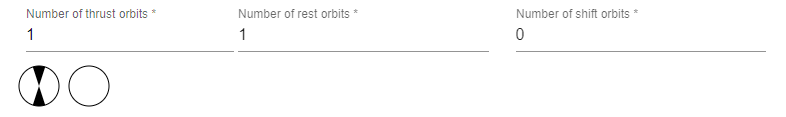

### Create Output Ephemerides Request
Here we set up the parameters for generating output ephemerides. We define the time step, specify the types of ephemerides data (Keplerian elements and power system information), and configure the spacecraft states to include mean elements.

In [ ]:

ephemerides_request = EphemeridesRequest(
    timestep=60.0,
    types=[EphemeridesRequest.EphemeridesType.KEPLERIAN, EphemeridesRequest.EphemeridesType.POWER_SYSTEM],
    mean=True,
    osculating=False
)

states_request = SpacecraftStatesRequest(mean=False, osculating=True)

### Create semi-major axis tolerance
This defines the allowable variation in the semi-major axis during station-keeping maneuvers

In [ ]:
tolerance = SemiMajorAxisTolerance(0.4)

## Build & Run Use Case

In [ ]:
sk = LeoStationKeeping.from_initial_orbital_state(
    initial_orbital_state=orbital_state,
    maximum_duration=86400 * 45,
    tolerance=tolerance,
    output_requests=[ephemerides_request, states_request],
    strategy=strategy,
    average_available_on_board_power=50,
    simulate_attitude_and_power_system=True
)

# Run the station keeping
sk.run()

## Post-processing

### Define Post-Processing Functions
Define auxiliary functions used to plot the results

In [ ]:
def draw_rectangles(_ax, start_dates, end_dates):
    if start_dates is None or end_dates is None or len(start_dates) == 0 or len(end_dates) == 0:
        return
    # get plot lims
    ymin, ymax = _ax.get_ylim()

    for start, end in zip(start_dates, end_dates):
        _ax.add_patch(Rectangle((start, ymin), end - start, ymax-ymin, color='red', alpha=0.2))

    # add a fake rectangle to the legend
    _ax.add_patch(Rectangle((0, 0), 0, 0, color='red', alpha=0.3, label="Firings"))

### Extract results

In [ ]:
roadmap = sk.result.generate_maneuver_roadmap()

firing_start_dates = [f.firing_start_date for f in roadmap.actions if isinstance(f, ActionFiring)]
firing_end_dates = [f.firing_end_date for f in roadmap.actions if isinstance(f, ActionFiring)]
quaternions = roadmap.actions[0].quaternions
dates = [q.date for q in quaternions]

# Export keplerian data
keplerian_data = sk.result.export_keplerian_ephemerides_data()
df_kep = pd.DataFrame(keplerian_data)

# Export power system data
system_data = sk.result.export_power_system_ephemerides_data()


### Plot Results

#### Keplerian Mean Elements

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 9))

axs[0].plot(df_kep['date'], df_kep['MeanSma'] - EARTH_RADIUS)
axs[0].set_title("Mean Altitude")
axs[0].set_ylabel("[km]")

axs[1].plot(df_kep['date'], df_kep['MeanEcc'])
axs[1].set_title("Mean Eccentricity")
axs[1].set_ylabel("[-]")

axs[2].plot(df_kep['date'], np.degrees(df_kep['MeanInc']))
axs[2].set_title("Mean Inclination")
axs[2].set_ylabel("[deg]")

for ax in axs:
    add_grid(ax)
    draw_rectangles(ax, firing_start_dates, firing_end_dates)

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[-1].set_xlabel("Date")

fig.autofmt_xdate()
fig.align_ylabels()
fig.tight_layout()
plt.show()

#### Quaternions

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 9))

q_i, q_j, q_k, q_r = [], [], [], []
for q in quaternions:
    q_i.append(q.i)
    q_j.append(q.j)
    q_k.append(q.k)
    q_r.append(q.real)

axs[0].plot(dates, q_i)
axs[0].set_ylabel("q_i")
axs[1].plot(dates, q_j)
axs[1].set_ylabel("q_j")
axs[2].plot(dates, q_k)
axs[2].set_ylabel("q_k")
axs[3].plot(dates, q_r)
axs[3].set_ylabel("q_r")

for ax in axs:
    add_grid(ax)
    draw_rectangles(ax, firing_start_dates, firing_end_dates)
    ax.set_xlim([firing_start_dates[0] - timedelta(hours=1), firing_start_dates[0] + timedelta(days=1)])

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[-1].set_xlabel("Date")

fig.autofmt_xdate()
fig.align_ylabels()
fig.tight_layout()
plt.show()


#### System Data

In [ ]:
if system_data is not None:
    df = pd.DataFrame(system_data)

    # Plot the battery charge
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 9))

    axs[0].plot(df['date'], df['battery_charge'])
    axs[0].set_title("Battery State")
    axs[0].set_ylabel("[-]")

    axs[1].plot(df['date'], df['solar_array_collected_power'])
    axs[1].set_title("Power available for charging")
    axs[1].set_ylabel("[W]")

    axs[2].plot(df['date'], df['thruster_power_consumption'])
    axs[2].set_title("Thruster Power Consumption")
    axs[2].set_ylabel("[W]")

    axs[3].plot(df['date'], df['thruster_warm_up_power_consumption'])
    axs[3].set_title("Thruster Warmup Power Consumption")
    axs[3].set_ylabel("[W]")

    for a in axs:
        add_grid(a)
        draw_rectangles(a, firing_start_dates, firing_end_dates)
        a.set_xlim([firing_start_dates[0] - timedelta(hours=1), firing_start_dates[0] + timedelta(days=1)])

    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[-1].set_xlabel("Date")

    fig.autofmt_xdate()
    fig.align_ylabels()
    fig.tight_layout()

    plt.show()

### Print Report

In [ ]:
report = sk.result.report

print("Station Keeping Report")
print("Total delta-v", report.total_delta_v, " m/s")
print("Thrust duration", report.thrust_duration, " s")
print("Number of burns", report.number_of_burns)
print("Simulation duration", report.simulation_duration/86400, " days")
print("Total consumption", report.total_consumption, " kg")